# SQL on BigQuery

```
SELECT limit_balance, sex, education_level, marital_status, age, 
       pay_0, pay_2, pay_3, pay_4, pay_5, pay_6, 
       bill_amt_1, bill_amt_2, bill_amt_3, bill_amt_4, bill_amt_5, bill_amt_6, 
       pay_amt_1, pay_amt_2, pay_amt_3, pay_amt_4, pay_amt_5, pay_amt_6,
       default_payment_next_month
FROM `bigquery-public-data.ml_datasets.credit_card_default`
LIMIT 37981
```

# 1 - Perkenalan

## 1.1 - Identity

  Nama : Jason Rich Darmawan Onggo Putra
  
  Batch : 016 RMT

## 1.2 - Dataset Overview

## 1.3 - Objective

  > Buatlah model Classification untuk memprediksi default_payment_next_month menggunakan dataset yang sudah kalian simpan.

  Choose an algorithm with default parameters that have the best metrics. Then, improve the algorithm with tuned parameters.

  The algorithm should have metircs:
  1. accuracy score of 0.8
  2. recall score of 0.9 for class 1
  3. precision score of 0.9 for class 1
  4. f1 score of 0.9 for class 1.

# 2 - Import Libraries

In [1]:
# Data Loading
import pandas as pd

# EDA
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats

# Data Preprocessing
from sklearn.model_selection import train_test_split
# from imblearn.pipeline import Pipeline, make_pipeline
# from imblearn.over_sampling import RandomOverSampler, SMOTENC
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler, MinMaxScaler, OrdinalEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer

# Model Definition
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

# Model Evaluation
from sklearn.model_selection import cross_validate, StratifiedShuffleSplit
from sklearn.metrics import make_scorer, recall_score, precision_score, f1_score, balanced_accuracy_score, classification_report

# Model Tuning
from sklearn.model_selection import GridSearchCV

# Model Saving
import joblib

# 3 - Data Loading

In [2]:
# Load Dataset
data_set = pd.read_csv("./h8dsft_P1M1_jason_rich_darmawan_onggo_putra.csv")

## 3.1 - Columns Data Types

In [3]:
# head and tail
data_set

,limit_balance,sex,education_level,marital_status,age,pay_0,pay_2,pay_3,pay_4,pay_5,...,bill_amt_4,bill_amt_5,bill_amt_6,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,pay_amt_6,default_payment_next_month
0,50000,1,3,0,50,0,0,0,-1,-1,...,3400,2769,0,2266,0,3400,2769,1700,0,0
1,200000,2,3,0,45,-2,-2,-2,-2,-2,...,399,1396,0,2430,0,399,1396,0,0,0
2,130000,1,1,1,45,0,0,0,0,0,...,62377,63832,65099,2886,2908,2129,2354,2366,2291,0
3,230000,1,2,1,41,0,0,0,0,0,...,216260,215968,174195,9405,7769,7757,8030,6549,5226,1
4,50000,1,2,1,42,0,0,0,0,0,...,31320,36227,35569,2007,2000,1500,5400,0,3000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2960,320000,1,2,1,41,1,-2,-2,-2,-2,...,0,700,860,0,0,0,700,860,2420,1
2961,20000,1,1,1,39,-1,-1,-1,-1,-1,...,630,664,598,700,600,700,700,600,1400,0
2962,20000,1,2,2,25,0,0,0,0,0,...,16600,17025,17381,1300,1300,1300,700,630,650,0
2963,50000,1,2,2,38,0,0,0,0,0,...,17833,18246,18642,1300,1600,650,700,700,700,0


## 3.2 - Columns Dtypes

- No missing values
- [x] Change columns dtypes to 'object': 'sex', 'education_level', 'marital_status', 'default_payment_next_month'
- [x] Change columns dtypes to 'category': 'pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6' [outline](#41---what-are-pay_0-bill_amt_1-pay_amt_1)

- Numerical data: 
  - 'limit_balance', 'age'
  - 'bill_amt_1', 'bill_amt_2', 'bill_amt_3', 'bill_amt_4', 'bill_amt_5', 'bill_amt_6'
  - 'pay_amt_1', 'pay_amt_2', 'pay_amt_3', 'pay_amt_4', 'pay_amt_5', 'pay_amt_6'
- Nominal data: 
  - 'sex'
  - 'education_level'
    
    Description:
    > Education Level (1=graduate school, 2=university, 3=high school, 4=others, 5=unknown, 6=unknown)
  - 'marital_status'
    
    Description:
    > Marital status (1=married, 2=single, 3=others)
- ordinal data: 'pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6' [outline](#41---what-are-pay_0-bill_amt_1-pay_amt_1)

Rules for pandas dtypes:
1. ordinal use 'category' dtypes.
2. nominal use 'object' dtypes.
3. numerical use 'number' dtypes.
4. target use 'category' dtypes. due to issue with sklearn.

In [4]:
# find the columns dtypes
data_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2965 entries, 0 to 2964
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   limit_balance               2965 non-null   int64
 1   sex                         2965 non-null   int64
 2   education_level             2965 non-null   int64
 3   marital_status              2965 non-null   int64
 4   age                         2965 non-null   int64
 5   pay_0                       2965 non-null   int64
 6   pay_2                       2965 non-null   int64
 7   pay_3                       2965 non-null   int64
 8   pay_4                       2965 non-null   int64
 9   pay_5                       2965 non-null   int64
 10  pay_6                       2965 non-null   int64
 11  bill_amt_1                  2965 non-null   int64
 12  bill_amt_2                  2965 non-null   int64
 13  bill_amt_3                  2965 non-null   int64
 14  bill_amt

In [5]:
# change nominal data dtypes to object
data_set[['sex', 'education_level', 'marital_status']] = \
    data_set[['sex', 'education_level', 'marital_status']].astype('object')

In [6]:
type_pay0_pay6 = pd.api.types.CategoricalDtype(categories=[-2, -1, 0, 
                                                            1,  2, 3, 4, 5, 6, 7, 8, 9])

# change ordinal data dtypes to category
data_set[['pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6']] = \
    data_set[['pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6']].astype(type_pay0_pay6)

type_default_payment_next_month = pd.api.types.CategoricalDtype(categories=[0, 1])
data_set['default_payment_next_month'] = \
    data_set['default_payment_next_month'].astype(type_default_payment_next_month)

In [7]:
# get the columns
numerical_columns = data_set.select_dtypes(include='number').columns.to_numpy()
ordinal_columns = data_set.drop('default_payment_next_month', axis='columns') \
                          .select_dtypes(include='category').columns.to_numpy()
nominal_columns = data_set.select_dtypes(include='object').columns.to_numpy()

## 3.3 - Central Tendency

- [x] why is 'bill_amt_2' have minus values. [outline](#42---relationship-between-x-numerical-and-y-categorical)
- [x] why is 'bill_amt_2' have high maximum values. [outline](#42---relationship-between-x-numerical-and-y-categorical)

- the dataset is mildly imbalanced

- 'education_level' have unknown category '0', '5', '6' -> chnge it to '4'
- 'marital_status' have unknwon category '4' -> change it to '3'

In [8]:
# bill_amt_1 to bill_amt_6 have minus.
with pd.option_context("display.float_format", '{:,.0f}'.format):
    display(data_set.describe(include='number'))

,limit_balance,age,bill_amt_1,bill_amt_2,bill_amt_3,bill_amt_4,bill_amt_5,bill_amt_6,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,pay_amt_6
count,"2,965","2,965","2,965","2,965","2,965","2,965","2,965","2,965","2,965","2,965","2,965","2,965","2,965","2,965"
mean,"163,369",35,"52,118","50,649","48,240","44,090","40,956","39,773","6,349","6,272","5,150","4,561","4,913","5,383"
std,"125,030",9,"72,329","70,785","68,146","61,907","58,272","57,303","20,886","28,880","14,287","13,281","16,734","17,276"
min,"10,000",21,"-11,545","-67,526","-25,443","-46,627","-46,627","-73,895",0,0,0,0,0,0
25%,"50,000",28,"3,958","3,390","3,302","2,582","1,958","1,430","1,013",990,477,313,323,173
50%,"140,000",34,"24,257","23,111","21,520","19,894","18,814","18,508","2,234","2,175","1,994","1,600","1,646","1,615"
75%,"230,000",41,"69,852","67,827","63,023","58,622","53,373","52,287","5,087","5,000","4,500","4,000","4,021","4,081"
max,"800,000",69,"613,860","512,650","578,971","488,808","441,981","436,172","493,358","1,227,082","199,209","202,076","388,071","403,500"


In [9]:
# get the mode
data_set.describe(include=['category'])

,pay_0,pay_2,pay_3,pay_4,pay_5,pay_6,default_payment_next_month
count,2965,2965,2965,2965,2965,2965,2965
unique,11,10,9,10,9,8,2
top,0,0,0,0,0,0,0
freq,1516,1607,1610,1667,1702,1626,2330


In [10]:
# get the cardinality
data_set.describe(include=['object'])

,sex,education_level,marital_status
count,2965,2965,2965
unique,2,7,4
top,2,2,2
freq,1802,1400,1594


In [11]:
# unknown categories 0, 5, 6
data_set['education_level'].value_counts()

2    1400
1    1039
3     483
5      24
4      13
6       4
0       2
Name: education_level, dtype: int64

In [12]:
# unknown categories 4
data_set['marital_status'].value_counts()

2    1594
1    1332
3      35
0       4
Name: marital_status, dtype: int64

# 4 - Exploratory Data Analysis (EDA)

## 4.1 - what are 'pay_2', 'bill_amt_2', 'pay_amt_1'

- [x] Why is 'pay_0' have value '-2'

  > [-2: No consumption; -1: Paid in full; 0: The use of revolving credit; 1 = payment delay for one month; 2 = payment delay for two months; . . .; 8 = payment delay for eight months; 9 = payment delay for nine months and above.](https://www.kaggle.com/datasets/uciml/default-of-credit-card-clients-dataset/discussion/34608)

- [x] Is 'bill_amt_2' paid in 'pay_amt_1'?

  EDA shows there are a handful of people that paid in 'pay_amt_1' based on 'bill_amt_2'. Therefore, we assume that 'bill_amt_2' is billing statement of the month and paid 'pay_amt_1' in the next month.

  > [Billing statements are issued monthly at the end of each billing cycle.](https://www.investopedia.com/terms/b/billing-statement.asp)

Description:

- 'pay_0' 
  > Repayment status in September, 2005 (-1=pay duly, 1=payment delay for one month, 2=payment delay for two months, ... 8=payment delay for eight months, 9=payment delay for nine months and above)

- 'pay_2'
  > Repayment status in August, 2005 (scale same as above)

- 'bill_amt_1'
  > Amount of bill statement in September, 2005 (NT dollar)

- 'bill_amt_2'
  > Amount of bill statement in August, 2005 (NT dollar)

- 'pay_amt_1'
  > Amount of previous payment in September, 2005 (NT dollar)

- 'pay_amt_2' 
  > Amount of previous payment in August, 2005 (NT dollar)

Magic sentence: 'bill_amt_6' is paid by 'pay_amt_5' and affected the status 'pay_5'

In [13]:
# is bill_amt_6 paid in pay_amt_5 ?
# yes.
data_set.loc[(data_set['bill_amt_6'] == data_set['pay_amt_5']),
             ['pay_0', 'pay_2', 'pay_3',
              'bill_amt_1', 'bill_amt_2', 'bill_amt_3',
              'pay_amt_1', 'pay_amt_2', 'pay_amt_3']]

,pay_0,pay_2,pay_3,bill_amt_1,bill_amt_2,bill_amt_3,pay_amt_1,pay_amt_2,pay_amt_3
1,-2,-2,-2,399,2430,0,2430,0,399
75,0,0,0,21628,20893,5869,2000,3869,25128
164,0,0,0,110350,102556,103834,4052,6122,1987
181,0,0,0,296349,300155,305798,6891,8668,6907
247,0,0,0,113368,70001,45813,2354,2500,1200
...,...,...,...,...,...,...,...,...,...
2915,0,0,0,46780,38099,38600,1899,1400,1188
2917,-1,-1,-1,4330,8369,16786,8369,16786,396
2924,0,0,0,37412,38485,39575,2000,20000,1359
2959,1,-2,-2,-200,-200,-200,0,0,200


### 4.1.1 - Are there any errors?

In [14]:
errors_drop_miscalculation_index = []

def isolate():
    global errors_drop_miscalculation_index
    for columns in [
        ['bill_amt_4', 'bill_amt_5', 'pay_amt_4'],
        ['bill_amt_3', 'bill_amt_4', 'pay_amt_3'],
        ['bill_amt_2', 'bill_amt_3', 'pay_amt_2'],
        ['bill_amt_1', 'bill_amt_2', 'pay_amt_1']
    ]:
        # find errors
        # if a person overpay 'bill_amt_5' with 'pay_amt_4'
        # the 'bill_amt_4' should not be smaller than 'bill_amt_5' - 'pay_amt_4'
        errors = data_set.loc[
            ((data_set[columns[1]] - data_set[columns[2]]) < 0)
            & (data_set[columns[0]] < (data_set[columns[1]] - data_set[columns[2]]))
            , columns]
        display(errors)

        # drop
        errors_drop_miscalculation_index += errors.index.tolist()

isolate()

errors_drop_miscalculation_index = list(set(errors_drop_miscalculation_index))
print("errors to drop length", len(errors_drop_miscalculation_index))

,bill_amt_4,bill_amt_5,pay_amt_4


,bill_amt_3,bill_amt_4,pay_amt_3
1138,-202,1201,1302


,bill_amt_2,bill_amt_3,pay_amt_2
2052,-6,-3,0


,bill_amt_1,bill_amt_2,pay_amt_1
2029,-330,340,500
2332,-22,-11,0


errors to drop length 4


In [15]:
# customer paid in full, yet marked as 0 = using revolving credit
# see 'bill_amt_5' paid by 'pay_amt_4', yet the 'pay_4' is 0 instead of -1.
data_set.iloc[31:32][['pay_4', 'bill_amt_5', 'pay_amt_4', 'pay_5', 'bill_amt_6', 'pay_amt_5']]

,pay_4,bill_amt_5,pay_amt_4,pay_5,bill_amt_6,pay_amt_5
31,0,11790,11790,0,12045,430


In [16]:
# replace these with -1
errors_replace_mislabel_duly_paid_index = [[], [], [], [], []]

# 'bill_amt_6' is paid by 'pay_amt_5' and affected the status 'pay_5'
def isolate():
    global errors_replace_mislabel_duly_paid_index
    for index, columns in enumerate([
        ['pay_5', 'bill_amt_6', 'pay_amt_5'],
        ['pay_4', 'bill_amt_5', 'pay_amt_4'],
        ['pay_3', 'bill_amt_4', 'pay_amt_3'],
        ['pay_2', 'bill_amt_3', 'pay_amt_2'],
        ['pay_0', 'bill_amt_2', 'pay_amt_1']
    ]):
        # if 'pay_5' is 0
        # therefore, 'bill_amt_6' should be not equal 'pay_amt_5'
        errors = data_set.loc[
            (data_set[columns[0]] == 0)
            & (data_set[columns[1]] == data_set[columns[2]])
            , columns]
        # display(errors)

        errors_replace_mislabel_duly_paid_index[index] += errors.index.tolist()
        
isolate()

print("errors to replace length", sum(len(errors_replace_mislabel_duly_paid_index[i]) for i in np.arange(0,5)))

errors to replace length 451


In [71]:
# replace these with -1
errors_replace_mislabel_duly_paid_index_2 = [[], [], [], []]

errors_drop_mislabel_no_consumption_index = []

def isolate():
    global errors_replace_mislabel_duly_paid_index_2
    global errors_drop_mislabel_no_consumption_index
    # global errors_replace_to_duly_paid_index
    for index, columns in enumerate([
        # we can't be sure because we don't have 'bill_amt_7' column to compare
        # ['bill_amt_5', 'pay_5', 'bill_amt_6', 'pay_amt_5']

        ['pay_4', 'bill_amt_5', 'pay_amt_4', 'bill_amt_6'],
        ['pay_3', 'bill_amt_4', 'pay_amt_3', 'bill_amt_5'],
        ['pay_2', 'bill_amt_3', 'pay_amt_2', 'bill_amt_4'],
        ['pay_0', 'bill_amt_2', 'pay_amt_1', 'bill_amt_3']
    ]):
        # if 'pay_4' == -2 (no consumption)
        # then 'bill_amt_5' should be equal to 'bill_amt_6'
        # or 'bill_amt_5' should not be larger than 'bill_amt_6' - 'pay_amt_5'
        # to avoid dropping, we will do lateral solution
        # the commented part is the original solution to drop
        # the lateral solution:
        # 
        errors = data_set.loc[
            (data_set[columns[0]] == -2)
            & ( 
                (data_set[columns[1]] != data_set[columns[3]])
                # 'bill_amt_5' <= 'bill_amt_6'
                # if true then we know for a fact, it sohuld be -1 instead of -2
                & (data_set[columns[1]] <= data_set[columns[2]])

                # | (data_set[columns[1]] <= (data_set[columns[3]] - data_set[columns[1]]))
              )
            , columns]
        # with pd.option_context("display.max_rows", None):
        #     display(errors)

        errors_replace_mislabel_duly_paid_index_2[index] += errors.index.tolist()

        errors_2 = data_set.loc[
            # A person with pay_4 -2 / no consumption
            # should have 'bill_amt_5' equals to 'bill_amt_6'
            # 'bill_amt_5' should be < 'pay_amt_4' (pay in full)
            (data_set[columns[0]] == -2)
            & ( 
                (data_set[columns[1]] != data_set[columns[3]])
                # if 'bill_amt_5' > 'pay_amt_4' (did not pay in full)
                # we don't know if it's a revolving credit or late payment
                # therefore we will drop this row
                & (data_set[columns[1]] > data_set[columns[2]])

                # | (data_set[columns[1]] <= (data_set[columns[3]] - data_set[columns[1]]))
              )
            , columns]
        # with pd.option_context("display.max_rows", None):
        #     display(errors_2)

        errors_drop_mislabel_no_consumption_index += errors_2.index.tolist()

isolate()

print("errors to replace length", sum(len(errors_replace_mislabel_duly_paid_index_2[i]) for i in np.arange(0,4)))

errors_drop_mislabel_no_consumption_index = list(set(errors_drop_mislabel_no_consumption_index))
print("errors to drop length", len(errors_drop_mislabel_no_consumption_index))

errors to replace length 749
errors to drop length 19


## 4.2 - Relationship between X Numerical and y Categorical

**'limit_balance'**:
1. Person with 'default_payment_next_month' '0' have 'limit_balance' over 500,000.

'age':
1. No difference between person with 'default_payment_next_month' '1' in age.

'bill_amt_1', 'bill_amt_2', 'bill_amt_3', 'bill_amt_4', 'bill_amt_6':
1. The outliers are worrying. However, these outliers are natural outliers.
   
   This assumption is based on people that have 'bill_amt_2' > 164482.5, these people do not pay in full 'pay_amt_1' and labeled as 'pay_0' 0. This means that 0 is the use of revolving credit.
3. [x] Check if 'bill_amt_1' and so on are larger than 'limit_balance'  
   We can't determine a data as errors using this method. Some credit card companies offer the ability to over-limit on your credit card account. 

   > [If you didn’t enable over-limit protection on your credit card account, your transaction will probably be declined. If you opted into over-limit protection, your charge might go through—but you could get hit with fees, higher interest rates or lower credit limits.](https://www.bankrate.com/finance/credit-cards/hefty-cost-of-going-over-the-limit/)

**'bill_amt_5'**:
1. A person with minus 'bill_amt_5' is definitely labeled as 'default_payment_next_month' '1'
  - [ ] If there is multicollinearity, use 'bill_amt_5'

'pay_amt_1', 'pay_amt_3', 'pay_amt_4', 'pay_amt_5', 'pay_amt_6':
1. The outliers are worrying. However, these outliers are natural outliers.
2. None of these features are a good separator for 'default_payment_next_month' '1'

**'pay_amt_3'**:
1. People that pay more than > 10,000 in 'pay_amt_2' is definitely labeled as 'default_payment_next_month' '0'
   - [ ] If there is multicollonearity, use 'pay_amt_3'

- [x] use `sklearn.preprocessing.RobustScaler` for every numerical data.

  - because every columns have outliers, and outliers are important to predict 'default_payment_next_month'.
  - using `sklearn.preprocessing.MinMaxScaler` is unwise because it will reduce the outliers weight.

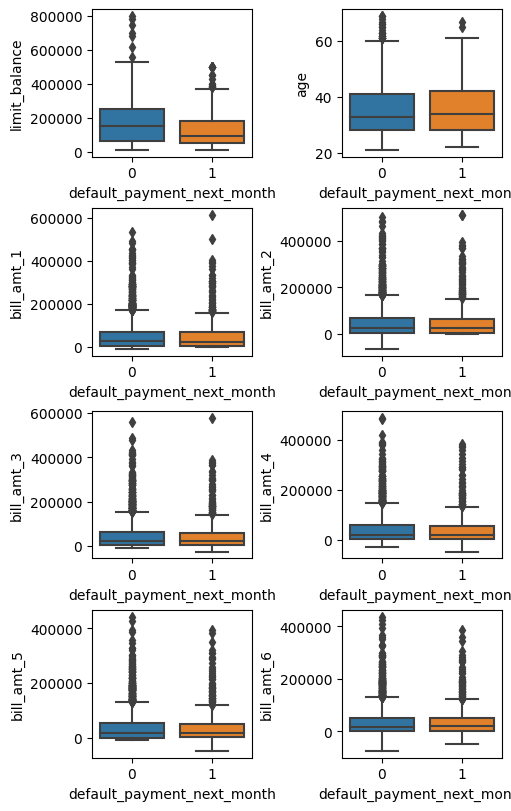

In [18]:
# prevent global variable
def isolate():
    fig, axes = plt.subplots(nrows=4, ncols=2, constrained_layout=True, figsize=(5,8))
    for column, ax in zip(['limit_balance', 'age', 'bill_amt_1', 'bill_amt_2',
                           'bill_amt_3', 'bill_amt_4', 'bill_amt_5', 'bill_amt_6'], axes.ravel()):
        sns.boxplot(data=data_set, x="default_payment_next_month", y=column, ax=ax)

isolate()

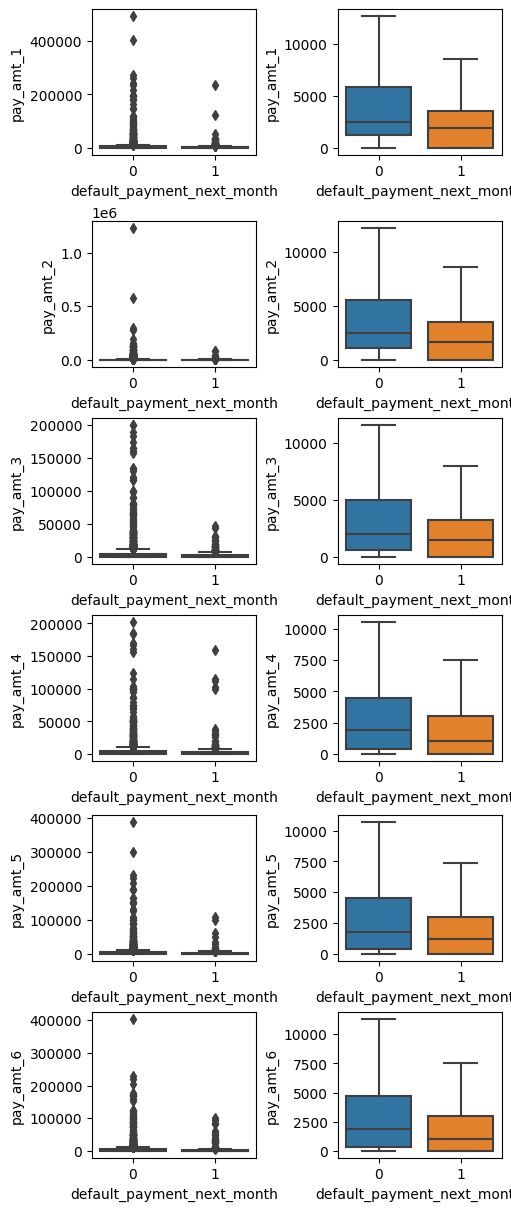

In [19]:
# left is with outliers
# right is without outliers
# none is a good separator for 'default_payment_next_month'
# however, we will choose 'pay_amt_3' to avoid losing too much information
# during feature selection
def isolate():
    fig, axes = plt.subplots(nrows=6, ncols=2, constrained_layout=True, figsize=(5,12))
    for i, column in zip(np.arange(axes.shape[0]),
                 ['pay_amt_1', 'pay_amt_2', 'pay_amt_3', 'pay_amt_4', 'pay_amt_5',
                  'pay_amt_6']):
        for j in np.arange(axes.shape[1]):
            if j % 2 != 0:
                sns.boxplot(data=data_set, x="default_payment_next_month", y=column, ax=axes[i][j], showfliers=False)
                continue
            sns.boxplot(data=data_set, x="default_payment_next_month", y=column, ax=axes[i][j])        

isolate()

In [20]:
# get skew of numerical columns
# every numerical columns are moderately or highly skewed to the right
# use RobustScaler!
def isolate():
    display(data_set[numerical_columns].skew())
isolate()

limit_balance     1.000442
age               0.772887
bill_amt_1        2.484598
bill_amt_2        2.458349
bill_amt_3        2.569937
bill_amt_4        2.448175
bill_amt_5        2.400343
bill_amt_6        2.432406
pay_amt_1        11.877647
pay_amt_2        29.404261
pay_amt_3         8.044639
pay_amt_4         8.451541
pay_amt_5        11.468890
pay_amt_6         9.760184
dtype: float64

In [21]:
# prevent global variable
# get the lower fence and upper fence
def isolate():
    q1, q3 = data_set['bill_amt_2'].quantile([.25, .75])
    iqr = q3 - q1
    print(q1 - 1.5*iqr, q3 + 1.5*iqr)

isolate()

-93265.5 164482.5


In [22]:
# check the value of 'pay_2' of person with 'bill_amt_2' > 120k
# 'bill_amt_2' does not need to be paid in full.
data_set.loc[data_set['bill_amt_2'] > 164482.5, ['pay_0', 'bill_amt_2', 'pay_amt_1']][:10]

,pay_0,bill_amt_2,pay_amt_1
3,0,305327,9405
9,0,195970,7822
10,0,167378,54209
12,0,173440,8083
13,0,171565,20000
14,0,176294,5519
16,0,254078,9251
28,0,177644,6100
29,0,295998,13200
33,0,169969,8450


## 4.3 - Relationship X Categorical and y Categorical

- Nominal columns can't give good indication, alone, to label a person as 'default_payment_next_month' '1'. We need to check for collinearity.

- Ordinal columns 'pay_6' to 'pay_0' are good separator of instance with 'default_payment_next_month' '1'. 
  - [ ] There are definitely multicollinearity. If it is true, use 'pay_0'
  
  A person is more likely to defaulted after delaying payments for 2 months.

- [ ] Handle infrequent ordinal in 'pay_0' to 'pay_6' with params `handle_unknown='infrequent_if_exist', max_categories=6, min_frequency=0.011`

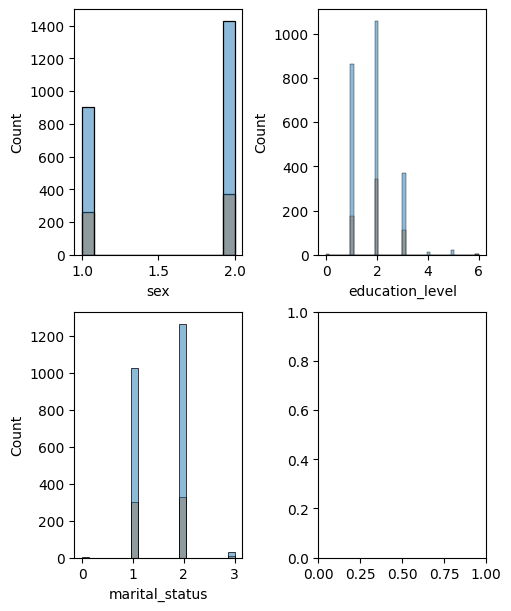

In [23]:
# prevent global variable
def isolate():
    fig, axes = plt.subplots(nrows=2, ncols=2, constrained_layout=True, figsize=(5,6))
    for column, ax in zip(nominal_columns, axes.ravel()):
        sns.histplot(data=data_set, x=column, hue="default_payment_next_month", ax=ax)
        ax.get_legend().remove()
        
isolate()

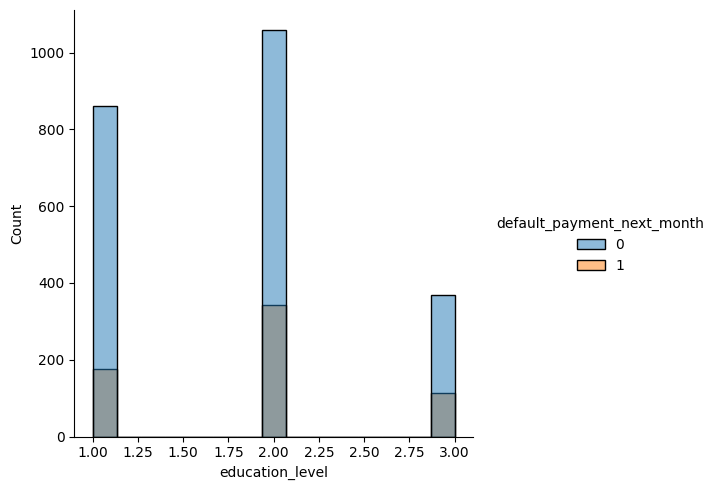

In [24]:
# Focus on 'education_level' 1, 2, 3
# This is because we will merge 0, 4, 5, 6 to 'education_level' 3
# We can see that people with 'education_level' 1, 2, 3 ratio is similar.
sns.displot(data=data_set[data_set['education_level'].isin([1,2,3])], 
            x='education_level', hue='default_payment_next_month')

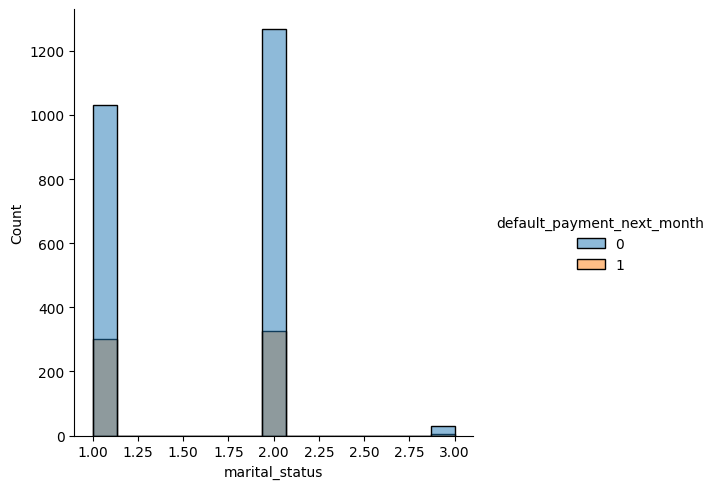

In [25]:
# Focus on 'marital_status' 1, 2, 3
# This is because we will merge 0 to 'marital_status' 3
# We can see that the ratio between 'marital_status' 1, 2, 3 is similar
sns.displot(data=data_set[data_set['marital_status'].isin(values=[1, 2, 3])], 
            x="marital_status", hue="default_payment_next_month")

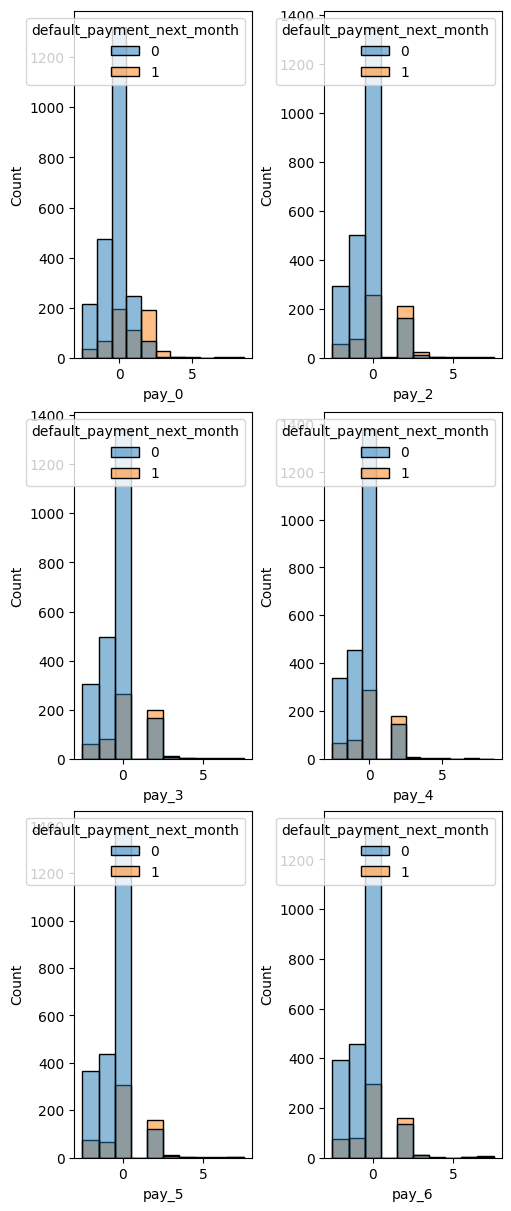

In [26]:
# We can see a pattern here
# People that have payment delay for more than 1 months are more likely to be labeled
# as 'default_payment_next_month' 1
# e.g 'pay_0' 2
def isolate():
    fig, axes = plt.subplots(nrows=3, ncols=2, constrained_layout=True, figsize=(5,12))
    for column, ax in zip(ordinal_columns, axes.ravel()):
        sns.histplot(data=data_set, x=column, hue="default_payment_next_month", 
                     ax=ax)

isolate()

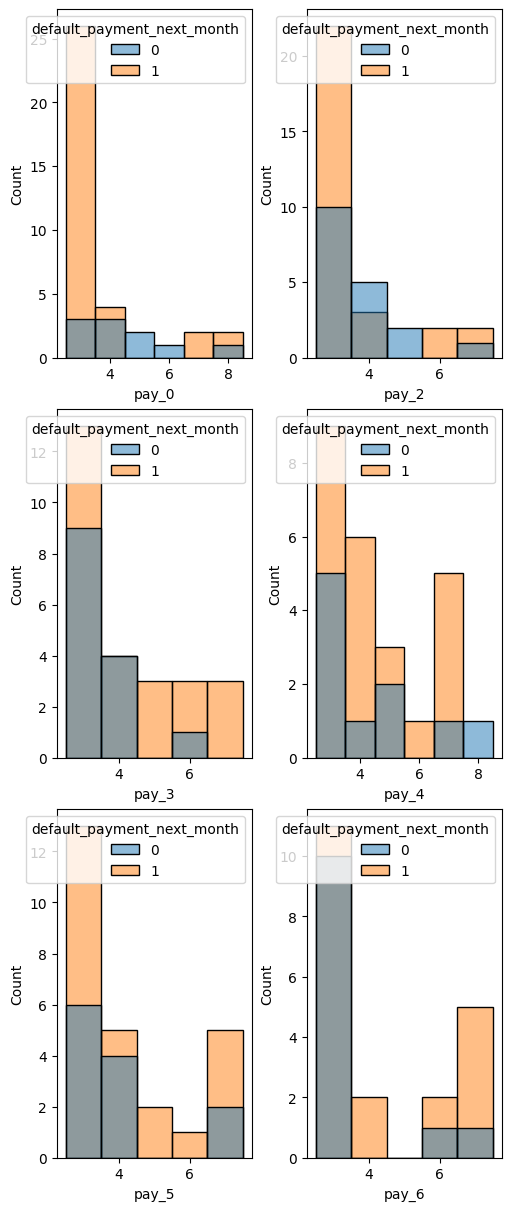

In [27]:
# Focus on data with criteria: payment delay for more than 2 months
# We can see that after 2 months, people is more likely to be labeled as
# 'default_payment_next_month' 1
# However, there are some cases where if the payment delayed for exactly 5 months
# that person will be labeled as 'payment_default_next_month' 1
# Verdict: merge 'pay_0' 3, 4, 5, 6, 7, 8, 9 to 'infrequent_sklearn'
def isolate():
    fig, axes = plt.subplots(nrows=3, ncols=2, constrained_layout=True, figsize=(5,12))
    for column, ax in zip(ordinal_columns, axes.ravel()):
        sns.histplot(data=data_set[data_set[column].isin(values=[3,4,5,6,7,8,9])], 
                     x=column, hue="default_payment_next_month", ax=ax)

isolate()

In [28]:
# 'education_level' 4 / others have 13 counts
# equals to 0.4% of the population
13/2965

0.004384485666104553

In [29]:
# We will label 'education_level' 0, 5, 6 as infrequent_sklearn
# the min_frequency should be 0,4%
data_set['education_level'].value_counts().sort_index()

0       2
1    1039
2    1400
3     483
4      13
5      24
6       4
Name: education_level, dtype: int64

## 4.4 - Imbalance Dataset

[reference](https://developers.google.com/machine-learning/data-prep/construct/sampling-splitting/imbalanced-data)

The dataset is imbalanced. The dataset set is have high variations as well.

Therefore, do not do under sampling to avoid losing information.

- [ ] Check if the correlation between X and y is strong, if not, do not do over sampling as well.

In [30]:
# Check if the dataset is imbalanced.
data_set['default_payment_next_month'].value_counts()

0    2330
1     635
Name: default_payment_next_month, dtype: int64

In [31]:
# Check if high variations:
# Out of 2964 rows, only 32 is duplicated.
data_set[['limit_balance', 'bill_amt_5', 'pay_amt_2', 'pay_0', 'sex', 'marital_status', 'education_level']].value_counts()

limit_balance  bill_amt_5  pay_amt_2  pay_0  sex  marital_status  education_level
200000         0           0          1      2    1               1                  4
80000          0           0          0      1    2               2                  3
210000         0           0          1      2    2               1                  3
150000         0           0          -2     2    1               2                  3
360000         0           0          1      2    1               1                  3
                                                                                    ..
80000          23229       2500       1      1    2               1                  1
               23304       5          0      2    2               2                  1
               23601       2000       0      1    2               1                  1
               24439       4000       2      2    2               2                  1
800000         12590       64657      -1     1  

# 5 - Data Preprocessing
  > Bagian ini berisi proses penyiapan data untuk proses pelatihan model, seperti pembagian data menjadi train-dev-test, transformasi data (normalisasi, encoding, dll.), dan proses-proses lain yang dibutuhkan.

In [32]:
# Split dataset to Inference Set
inference_set = data_set.groupby(by='default_payment_next_month') \
                        .sample(5, random_state=17)

# Remove Inference Set from dataset
data_train_test = data_set.drop(inference_set.index)

In [33]:
# Split dataset to X and y
X = data_train_test.drop(['default_payment_next_month'], axis=1)
y = data_train_test['default_payment_next_month']
print("X", X.shape, "y", y.shape)

X (2955, 23) y (2955,)


In [34]:
# Split dataset to Train Set and Test Set
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=17,
                                                    stratify=y)

print("X_train", X_train.shape, "y_train", y_train.shape)
print("X_test", X_test.shape, "y_test", y_test.shape)

X_train (2364, 23) y_train (2364,)
X_test (591, 23) y_test (591,)


## 5.1 Handling Errors

We will only drop or replace errors on train set. The intention is that the test set is inputs from user. Therefore, unintentional errors can't be corrected by Data Scientist.

In [35]:
def isolate():
    # Handle 'education_level' 0, 5, 6; replace with 4
    # This is changed instead of set to 'sklearn_infrequent'
    # because there are 'others' category in both features
    education_level = ((data_set['education_level'] == 0)
                      | (data_set['education_level'] == 5)
                      | (data_set['education_level'] == 6))
    X_train.loc[education_level, 'education_level'] = 4

    # Handle 'marital_status' 0; replace with 3
    marital_status = (data_set['marital_status'] == 0)
    X_train.loc[marital_status, 'marital_status'] = 3

isolate()

In [36]:
def isolate():
    # A person overpay a bill statement
    # The next bill should not be smaller than the overpaid amount.
    X_train.drop(index=X_train.filter(items=errors_drop_miscalculation_index, axis=0).index,
                 inplace=True)
    y_train.drop(index=y_train.filter(items=errors_drop_miscalculation_index, axis=0).index,
                 inplace=True)
    
    # A person paid a bill statement in full
    # The repayment status should be -1 instead of 0
    # Backwards: 'pay_5' -> 'pay_4' -> 'pay_3' -> 'pay_2' -> 'pay_0'
    for column, indexes in zip(['pay_5', 'pay_4',
                                'pay_3', 'pay_2',
                                'pay_0'], errors_replace_mislabel_duly_paid_index):
        X_train.loc[X_train.filter(items=indexes, axis=0).index, column] = -1

    for column, indexes in zip(['pay_4', 'pay_3',
                                'pay_2', 'pay_0'], errors_replace_mislabel_duly_paid_index_2):
        X_train.loc[X_train.filter(items=indexes, axis=0).index, column] = -1

    # A person with no consumption in that month 
    # e.g 'pay_4' -2
    # should have 'bill_amt_5' equals to 'bill_amt_6'
    # 'bill_amt_5' should be < 'pay_amt_4' (pay in full)
    X_train.drop(index=X_train.filter(items=errors_drop_mislabel_no_consumption_index, axis=0).index,
                 inplace=True)
    y_train.drop(index=y_train.filter(items=errors_drop_mislabel_no_consumption_index, axis=0).index,
                 inplace=True)

# Instructor recommended us not to drop the data.
# This is because we need to confirm whether these are errors
# We need to confirm these with the dataset owner.
# isolate()

# check if rows are equal
print(X_train.shape, y_train.shape)

# check the imbalance
print(y_train.value_counts())

(2364, 23) (2364,)
0    1860
1     504
Name: default_payment_next_month, dtype: int64


## 5.2 - Pipeline

Pipeline to handle outliers, missing values, do feature engineering (scaling, encoding).

In [37]:
# feature scaling
numerical_transformer = Pipeline(
    steps=[
        # the numerical columns have natural outliers.
        ('imputer', SimpleImputer(strategy="median")),
        # the numerical columns are moderately to highly skewed to the right.
        # therefore StandardScaler is not a good fit.
        # and, MinMaxScaler is not a good fit due to 'min' and 'max' 
        # will be the outliers.
        ('scaler', RobustScaler())
    ]
)

# feature encoding
ordinal_transformer = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy="most_frequent")),
        ('encoder', OrdinalEncoder(categories=[
                                    type_pay0_pay6.categories,
                                    type_pay0_pay6.categories,
                                    type_pay0_pay6.categories,
                                    type_pay0_pay6.categories,
                                    type_pay0_pay6.categories,
                                    type_pay0_pay6.categories],
                                   # handle unknown categories with np.nan
                                   handle_unknown='use_encoded_value',
                                   unknown_value=np.nan)),
        # scaled with MinMaxScaler because we know the boundary of each ordinal.
        ('scaler', MinMaxScaler())
    ]
)

nominal_transformer = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy="most_frequent")),
        # drop='first' to avoid multicollinearity
        # handle_unknown='ignore' to handle the model with never seen data
        ('encoder', OneHotEncoder(drop='first', handle_unknown='infrequent_if_exist',
                                  # 'sex' have 2 unique values
                                  # 'marital_status' (after preprocessing) have 3 unique values
                                  # 'education_level' (after preprocessing) have 4 unique values
                                  # therefore, max_categories = 4 + 'sklearn_infrequent' 
                                  max_categories=5))
    ]
)

transformers = ColumnTransformer(
    transformers=[
        ("numerical", numerical_transformer, numerical_columns),
        ("ordinal", ordinal_transformer, ordinal_columns),
        ("nominal", nominal_transformer, nominal_columns)
    ],
)

# preprocessor for end-to-end
# WARNING: if we do over sampling 
# make sure to use `imblearn.pipeline` instead of `sklearn.pipeline`
# to avoid data leakage when cross validation
preprocessor = Pipeline(
    steps=[
        ('columntransformer', transformers),
    ]
)

## 5.3 - Multicollinearity

- [x] use data that have been preprocessed.

- [x] drop columns 'bill_amt_6', 'bill_amt_2', 'bill_amt_4', 'bill_amt_3', 'age'
- [x] drop columns 'pay_5', 'pay_2'
- [x] drop column 'education_level'

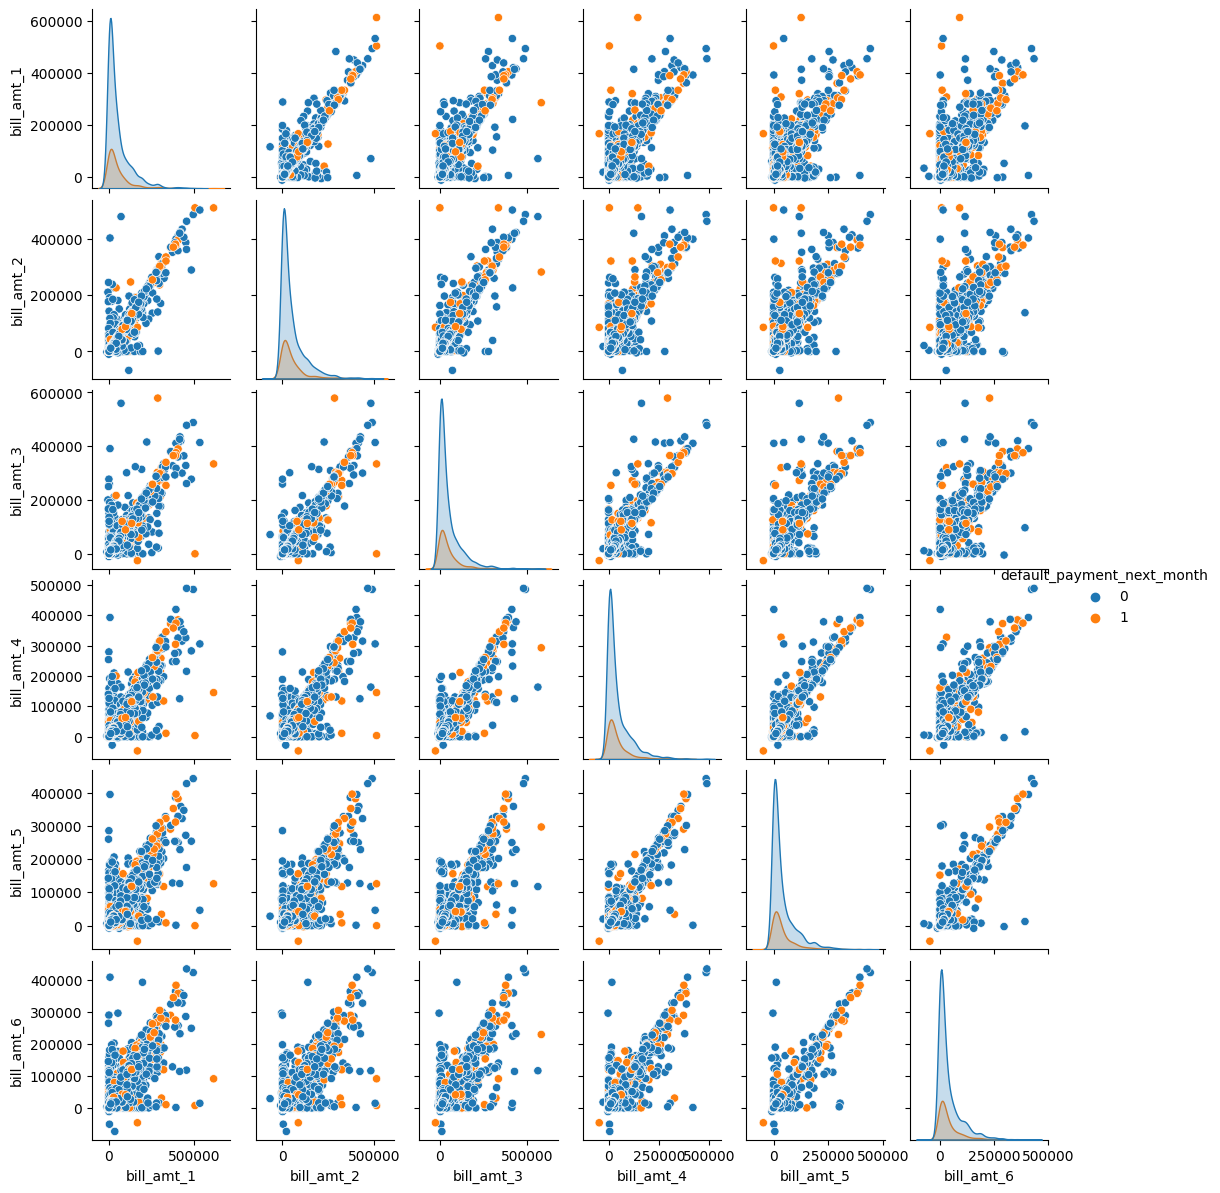

In [38]:
# check linear or non linear
# this is a must because there are linear and nonlinear bivariate relationship
# this is because pearson is not the right choice for non linear
# our focus is 'bill_amt_1' to 'bill_amt_6'
def isolate():
    g = sns.pairplot(data=data_set[['bill_amt_1', 'bill_amt_2',
                                    'bill_amt_3', 'bill_amt_4',
                                    'bill_amt_5', 'bill_amt_6', 'default_payment_next_month']], hue="default_payment_next_month")
    g.fig.set_size_inches(12,12)

isolate()

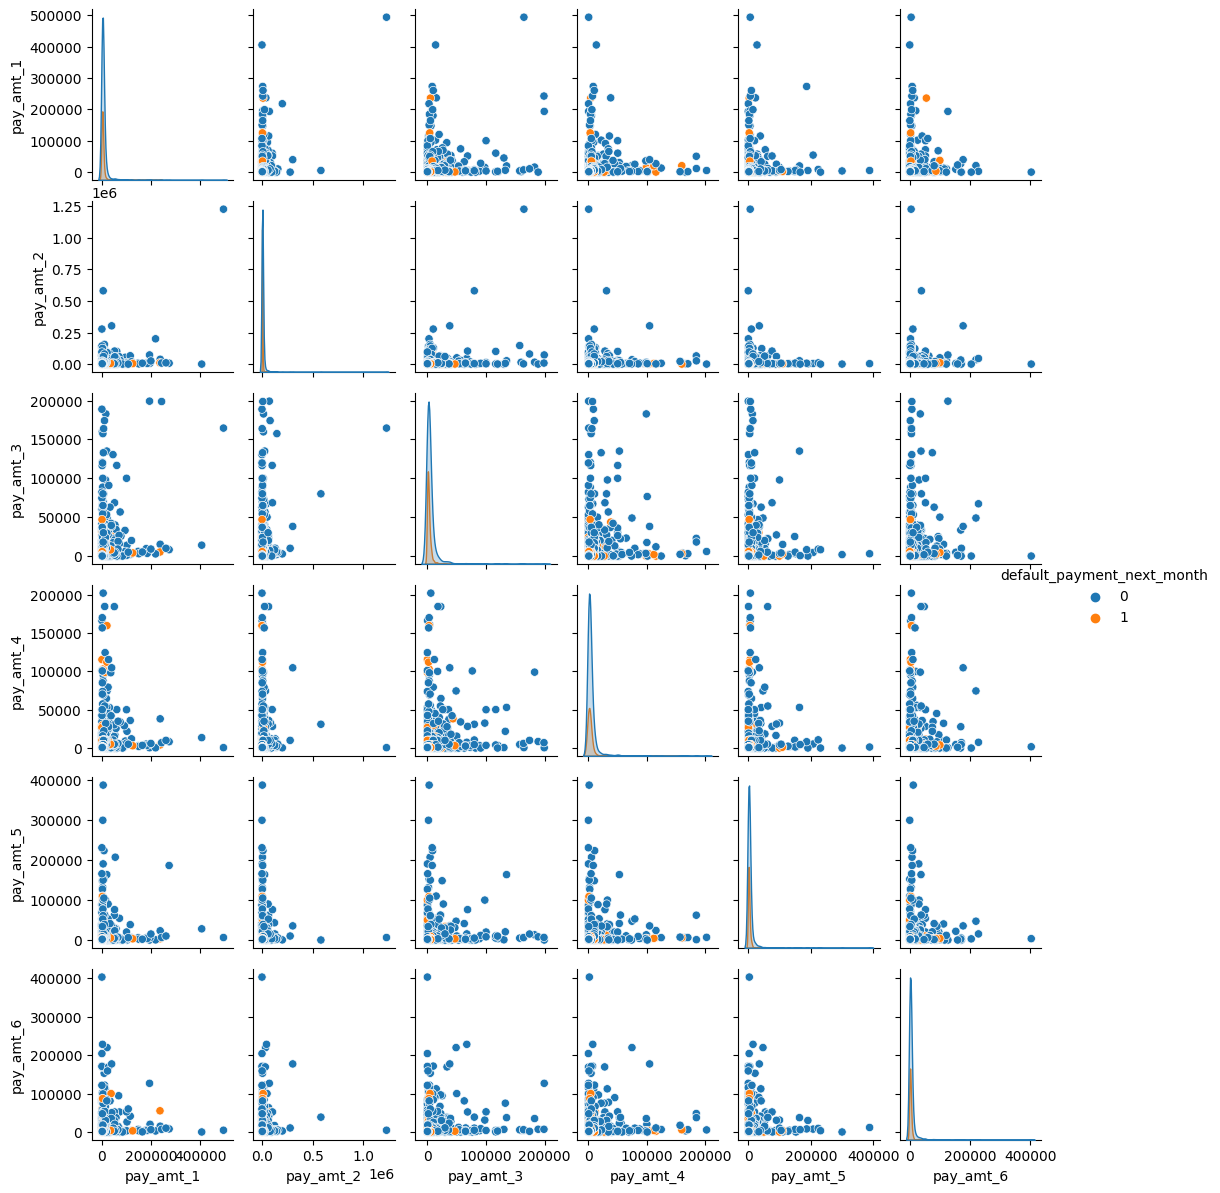

In [39]:
# check linear or non linear
# this is a must because there are linear and nonlinear bivariate relationship
# this is because pearson is not the right choice for non linear
# our focus is 'pay_amt_1' to 'pay_amt_6'
def isolate():
    g = sns.pairplot(data=data_set[['pay_amt_1', 'pay_amt_2',
                                    'pay_amt_3', 'pay_amt_4',
                                    'pay_amt_5', 'pay_amt_6', 'default_payment_next_month']], hue="default_payment_next_month")
    g.fig.set_size_inches(12,12)

isolate()

In [40]:
def get_Xy_train_final_df():
    X_train_final = preprocessor.fit_transform(X=X_train)
    Xy_train_final_df = pd.DataFrame(
        data=np.concatenate([X_train_final, y_train.values.reshape(-1,1)], axis=1),
        columns=np.concatenate([preprocessor.get_feature_names_out(), ['default_payment_next_month']], axis=0)
    )

    return Xy_train_final_df

In [41]:
# check multicollinearity with pearson for numerical.
def isolate():
    # change numerical_columns to columns to see the effect
    global numerical_columns_selected
    numerical_columns_selected = \
        numerical_columns[np.where(~np.in1d(numerical_columns, 
                                            ['bill_amt_3', 'bill_amt_4',
                                             'bill_amt_2', 'bill_amt_1',
                                             'bill_amt_6', 'pay_amt_1',
                                             'pay_amt_2', 'pay_amt_4',
                                             'pay_amt_5', 'pay_amt_6']))]
    
    Xy_train_final_df = get_Xy_train_final_df()

    df_columns = np.concatenate([
        ["numerical__" + column for column in numerical_columns_selected],
        ["default_payment_next_month"]
    ])

    display(Xy_train_final_df[df_columns].corr(method="pearson")
                                        .style.background_gradient(cmap='coolwarm'))

isolate()

,numerical__limit_balance,numerical__age,numerical__bill_amt_5,numerical__pay_amt_3,default_payment_next_month
numerical__limit_balance,1.000000,0.141614,0.306755,0.262293,-0.156979
numerical__age,0.141614,1.000000,0.052366,0.031681,0.018831
numerical__bill_amt_5,0.306755,0.052366,1.000000,0.224857,0.015362
numerical__pay_amt_3,0.262293,0.031681,0.224857,1.000000,-0.091685
default_payment_next_month,-0.156979,0.018831,0.015362,-0.091685,1.000000


In [42]:
# check multicollinearity with spearman for ordinal
# prevent global variable
# drop 'pay_5', 'pay_2'
def isolate():
    # columns do not contains column 'pay_5'
    global ordinal_columns_selected
    ordinal_columns_selected = \
        ordinal_columns[np.where(~np.in1d(ordinal_columns, ['pay_2', 'pay_3',
                                                            'pay_4', 'pay_5',
                                                            'pay_6']))]

    Xy_train_final_df = get_Xy_train_final_df()

    df_columns = np.concatenate([
        ["ordinal__" + column for column in ordinal_columns_selected],
        ["default_payment_next_month"]
    ], axis=0)

    display(Xy_train_final_df[df_columns].corr(method="spearman")
                                          .style.background_gradient(cmap="coolwarm"))

isolate()

,ordinal__pay_0,default_payment_next_month
ordinal__pay_0,1.000000,0.328567
default_payment_next_month,0.328567,1.000000


In [43]:
# reference: https://passel2.unl.edu/view/lesson/9beaa382bf7e/8#:~:text=If%20your%20chi%2Dsquare%20calculated,to%20reject%22%20your%20null%20hypothesis.
# p < 0.05 : education level - marital status observed deviations are significant.
# chi-square > critical value : reject null hypothesis. 
# alternative hypohesis: there are relationship between 'education_level' and 'marital_status'

def isolate():
    global nominal_columns_selected
    nominal_columns_selected = \
        nominal_columns[np.where(~np.in1d(nominal_columns, ['education_level']))]

    for i in range(len(nominal_columns_selected)):
        for j in range(len(nominal_columns_selected)):
            if i == j or i > j:
                continue
            
            print(f'{nominal_columns_selected[i]} - {nominal_columns_selected[j]}')
            
            chi2, p, dof, _ =  \
                scipy.stats.chi2_contingency(
                    observed=pd.crosstab(X_train[nominal_columns_selected[i]], 
                                         X_train[nominal_columns_selected[j]]))

            critical = scipy.stats.chi2.ppf(q=0.95, df=dof)
            print(f'chi2: {chi2:.2f} {chi2 > critical}; p: {p:.2f} {p < 0.05}; dof: {dof};')
isolate()

sex - marital_status
chi2: 1.10 False; p: 0.58 False; dof: 2;


## 5.4 - Pipeline (After Feature Selection)

Pipeline to handle outliers, missing values, do feature engineering (scaling, encoding).

In [44]:
# feature encoding
# 'education_level' is dropped
nominal_transformer_v2 = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy="most_frequent")),
        # drop='first' to avoid multicollinearity
        # handle_unknown='ignore' to handle the model with never seen data
        ('encoder', OneHotEncoder(drop='first',
                                  # sex have 2 unique values
                                  # marital_status have 3 unique values
                                  max_categories=4, 
                                  handle_unknown="infrequent_if_exist"))
    ]
)

# 'pay_5', 'pay_2' is dropped, so we have to remove it from the pipeline.
ordinal_transformer_v2 = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy="most_frequent")),
        ('encoder', OrdinalEncoder(categories=[
                                    type_pay0_pay6.categories,
                                   ],
                                   handle_unknown='use_encoded_value',
                                   unknown_value=np.nan)),
        ('scaler', MinMaxScaler())
    ]
)

## 5.5 - Preprocessor

In [45]:
# column transformer
transformers_v2 = ColumnTransformer(
    transformers=[
        ("numerical", numerical_transformer, numerical_columns_selected),
        ("ordinal", ordinal_transformer_v2, ordinal_columns_selected),
        ("nominal", nominal_transformer_v2, nominal_columns_selected)
    ],
)

# preprocessor for end-to-end
# WARNING: make sure to use `imblearn.pipeline` instead of `sklearn.pipeline`
# to avoid data leakage when cross validation
preprocessor_v2 = Pipeline(
    steps=[
        ('columntransformer', transformers_v2),
        # ('randomoversampler', RandomOverSampler(sampling_strategy=1.0, random_state=17))
    ]
)

# 6 - Model Definition
  > Bagian ini berisi cell untuk mendefinisikan model. Jelaskan alasan menggunakan suatu algoritma/model, hyperparameter yang dipakai, jenis penggunaan metrics yang dipakai, dan hal lain yang terkait dengan model.

In [46]:
# Logistic Regression
log_reg_default = make_pipeline(*preprocessor_v2, LogisticRegression(penalty="l2", C=1.0))

# SVM
svm_default = make_pipeline(*preprocessor_v2, SVC(C=1.0, kernel='rbf', gamma='scale'))

# Decision Tree
tree_clf_default = make_pipeline(*preprocessor_v2, 
                                 DecisionTreeClassifier(criterion="gini", 
                                                        max_depth=None, 
                                                        min_samples_leaf=1,
                                                        random_state=17,
                                                        max_features=None))

# KNN
knn_default = make_pipeline(*preprocessor_v2, KNeighborsClassifier(n_neighbors=5, metric='minkowski', p=2))

# Naive Bayes
nb_default = make_pipeline(*preprocessor_v2, GaussianNB())

# Random Forest
rf_clf_default = make_pipeline(*preprocessor_v2, 
                               RandomForestClassifier(n_estimators=100, 
                                                      criterion="gini", 
                                                      max_depth=None, 
                                                      min_samples_leaf=1,
                                                      random_state=17))

# 7 - Model Training
  > Cell pada bagian ini hanya berisi code untuk melatih model dan output yang dihasilkan. Lakukan beberapa kali proses training dengan hyperparameter yang berbeda untuk melihat hasil yang didapatkan. Analisis dan narasikan hasil ini pada bagian Model Evaluation.

## 7.1 - Default Parameter

In [47]:
# Logistic Regression
log_reg_default.fit(X=X_train, y=y_train)

# SVM
svm_default.fit(X=X_train, y=y_train)

# Decision Tree
tree_clf_default.fit(X=X_train, y=y_train)

# KNN
knn_default.fit(X=X_train, y=y_train)

# Naive Bayes
nb_default.fit(X=X_train, y=y_train)

# Random Forest
rf_clf_default.fit(X=X_train, y=y_train)

print("done")

done


## 7.2 - Model Tuning

  Goal: To find the best parameters for the algorithm.

  We are going to use `sklearn.model_selection.GridSearchCV` (based on best algorithm with default parameters)

  Task: 
  1. compare the metrics between algorithm with default parameters and best parameters.

  Although, SVM f1 score (train and test set) are better. We believe Random Forest have more room for improvement due to its ability to overfit with default parameter. We just need to do pruning.

  Therefore, algorithm with the best cross validate result is [Random Forest](#8116---random-forest).

### Ask Instructor

- [ ] How to use `sklearn.model_selection.GridSearchCV` to find the best score based on:
  - First filter: the least difference between train and test set metrics. 
  - Then, consider the highest metrics based on the first filter.
  - The current solution is only choose the highest metrics.

In [48]:
# weighted i.e
# recall weighted
# (f1 class 0 * support propotion class 0) +
# (f1 class 1 * support proportion class 1)
scoring = {
    'recall': make_scorer(score_func=recall_score, average='weighted'),
    'precision': make_scorer(score_func=precision_score, average='weighted', zero_division=0),
    'f1': make_scorer(score_func=f1_score, average='weighted'),
    'balanced_accuracy': make_scorer(score_func=balanced_accuracy_score)
}

### 7.2.1 - Random Forest

[refence](https://www.analyticsvidhya.com/blog/2020/03/beginners-guide-random-forest-hyperparameter-tuning/)

#### 7.2.1.1 - 'max_depth'

The recall score weighted (test set) stops increasing after max_depth 4. Then, the train set starts overfitting.

'best params'

{'randomforestclassifier__max_depth': 5}

best test recall score weighted 0.832908410076325


<AxesSubplot: >

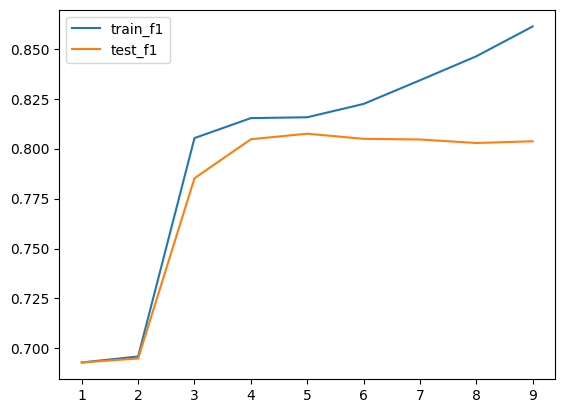

In [49]:
# model definition
rf_cv = GridSearchCV(estimator=rf_clf_default,
                     scoring=scoring,
                     refit="recall",
                     return_train_score=True,
                     param_grid={
                        'randomforestclassifier__max_depth': np.arange(start=1,stop=10,step=1),
                     },
                     n_jobs=-1)

rf_cv.fit(X=X_train, y=y_train)

display("best params", rf_cv.best_params_)
print("best test recall score weighted", rf_cv.best_score_)

sns.lineplot(x=rf_cv.cv_results_['param_randomforestclassifier__max_depth'], 
             y=rf_cv.cv_results_['mean_train_f1'], label="train_f1")
sns.lineplot(x=rf_cv.cv_results_['param_randomforestclassifier__max_depth'],
             y=rf_cv.cv_results_['mean_test_f1'], label="test_f1")


#### 7.2.1.2 - 'min_samples_split'

The recall score weighted (test set) stops increasing after min_samples_split 4. With this parameter, the model is overfitted. 

The model is starting to be a good fit after min_samples_split > 100.

'best params'

{'randomforestclassifier__max_depth': 5,
 'randomforestclassifier__min_samples_split': 4}

best test recall score weighted 0.83375407603827


<AxesSubplot: >

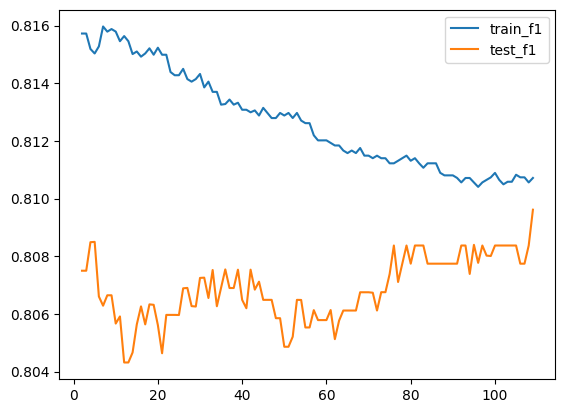

In [50]:
# model definition
rf_cv = GridSearchCV(estimator=rf_clf_default,
                     scoring=scoring,
                     refit="recall",
                     return_train_score=True,
                     param_grid={
                        'randomforestclassifier__max_depth': [5],
                        'randomforestclassifier__min_samples_split': np.arange(start=2,stop=110,step=1),
                     },
                     n_jobs=-1)

rf_cv.fit(X=X_train, y=y_train)

display("best params", rf_cv.best_params_)
print("best test recall score weighted", rf_cv.best_score_)

sns.lineplot(x=rf_cv.cv_results_['param_randomforestclassifier__min_samples_split'], 
             y=rf_cv.cv_results_['mean_train_f1'], 
             label="train_f1")
sns.lineplot(x=rf_cv.cv_results_['param_randomforestclassifier__min_samples_split'],
             y=rf_cv.cv_results_['mean_test_f1'], 
             label="test_f1")

#### 7.2.1.3 - 'max_leaf_nodes'

The recall score weighted (test set) stops increasing after max_leaf_nodes 4. However, there is no improvement if compared to the previous iteration. Therefore, we will not use this parameter.

The model is starting to be overfitted after max_samples_leaf_nodes 2.

'best params'

{'randomforestclassifier__max_depth': 5,
 'randomforestclassifier__max_leaf_nodes': 17,
 'randomforestclassifier__min_samples_split': 4}

best test recall score weighted 0.832908410076325


<AxesSubplot: >

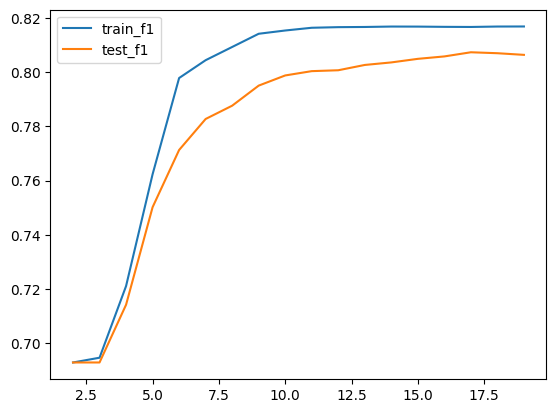

In [51]:
# model definition
rf_cv = GridSearchCV(estimator=rf_clf_default,
                     scoring=scoring,
                     refit="recall",
                     return_train_score=True,
                     param_grid={
                        'randomforestclassifier__max_depth': [5],
                        'randomforestclassifier__min_samples_split': [4],
                        'randomforestclassifier__max_leaf_nodes': np.arange(start=2, stop=20, step=1),
                     },
                     n_jobs=-1)

rf_cv.fit(X=X_train, y=y_train)

display("best params", rf_cv.best_params_)
print("best test recall score weighted", rf_cv.best_score_)

sns.lineplot(x=rf_cv.cv_results_['param_randomforestclassifier__max_leaf_nodes'], 
             y=rf_cv.cv_results_['mean_train_f1'], 
             label="train_f1")
sns.lineplot(x=rf_cv.cv_results_['param_randomforestclassifier__max_leaf_nodes'],
             y=rf_cv.cv_results_['mean_test_f1'], 
             label="test_f1")

#### 7.2.1.4 - 'min_samples_leaf'

The recall score weighted (test set) starts to decrease after min_samples_leaf 1. However, this is a default parameter. The recall score did not improve either compared to the last 2 iterations.

Therefore, we will not include this parameter.

The f1 score weighted (train and test set) starts to drop after min_samples_leaf 1. At this point, the model is a good fit.

'best params'

{'randomforestclassifier__max_depth': 5,
 'randomforestclassifier__min_samples_leaf': 1,
 'randomforestclassifier__min_samples_split': 4}

best test recall score class 1 0.83375407603827


<AxesSubplot: >

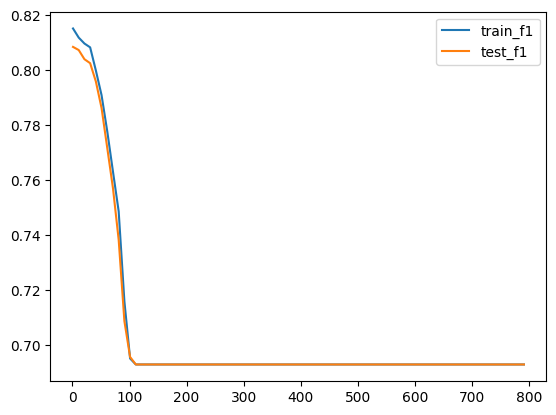

In [52]:
# model definition
rf_cv = GridSearchCV(estimator=rf_clf_default,
                     scoring=scoring,
                     refit="recall",
                     return_train_score=True,
                     param_grid={
                        'randomforestclassifier__max_depth': [5],
                        'randomforestclassifier__min_samples_split': [4],
                        # 'randomforestclassifier__max_leaf_nodes': [17],
                        'randomforestclassifier__min_samples_leaf': np.arange(start=1, stop=800, step=10),
                     },
                     n_jobs=-1)

rf_cv.fit(X=X_train, y=y_train)

display("best params", rf_cv.best_params_)
print("best test recall score class 1", rf_cv.best_score_)

sns.lineplot(x=rf_cv.cv_results_['param_randomforestclassifier__min_samples_leaf'], 
             y=rf_cv.cv_results_['mean_train_f1'], 
             label="train_f1")
sns.lineplot(x=rf_cv.cv_results_['param_randomforestclassifier__min_samples_leaf'],
             y=rf_cv.cv_results_['mean_test_f1'], 
             label="test_f1")

#### 7.2.1.5 - 'n_estimators'

The recall score weighted stops increasing after n_estimators 96.

The f1 score weighted shows that the model is a good fit.

'best params'

{'randomforestclassifier__max_depth': 5,
 'randomforestclassifier__min_samples_split': 4,
 'randomforestclassifier__n_estimators': 96}

best test recall score weighted 0.8341769090192426


<AxesSubplot: >

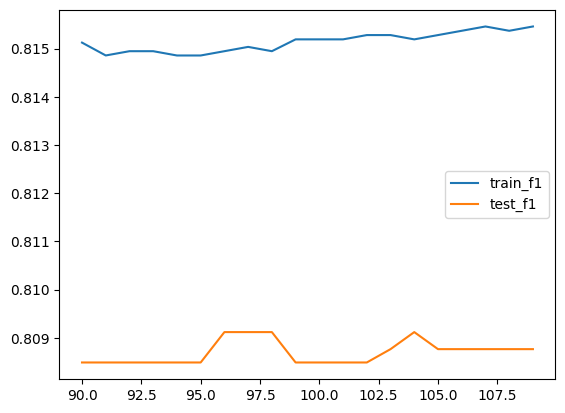

In [53]:
# model definition
rf_cv = GridSearchCV(estimator=rf_clf_default,
                     # what the user care is the model ability to find class 1.
                     # but if the precision is low, it will cause miss opportunity
                     # for the bank to loan money
                     scoring=scoring,
                     refit="recall",
                     return_train_score=True,
                     param_grid={
                        'randomforestclassifier__max_depth': [5],
                        'randomforestclassifier__min_samples_split': [4],
                        # 'randomforestclassifier__max_leaf_nodes': [17],
                        # 'randomforestclassifier__min_samples_leaf': [1],
                        'randomforestclassifier__n_estimators': np.arange(start=90, stop=110, step=1),
                     },
                     n_jobs=-1)

rf_cv.fit(X=X_train, y=y_train)

display("best params", rf_cv.best_params_)
print("best test recall score weighted", rf_cv.best_score_)

sns.lineplot(x=rf_cv.cv_results_['param_randomforestclassifier__n_estimators'], 
             y=rf_cv.cv_results_['mean_train_f1'], 
             label="train_f1")
sns.lineplot(x=rf_cv.cv_results_['param_randomforestclassifier__n_estimators'],
             y=rf_cv.cv_results_['mean_test_f1'], 
             label="test_f1")

#### 7.2.1.6 - 'max_samples'

> If float, then draw max_samples * X.shape[0] samples. Thus, max_samples should be in the interval (0.0, 1.0].

The recall score weighted stops increasing after max_samples 0.9

The f1 score weighted shows that this model is a good fit.

'best params'

{'randomforestclassifier__max_depth': 5,
 'randomforestclassifier__max_samples': 0.9,
 'randomforestclassifier__min_samples_split': 4,
 'randomforestclassifier__n_estimators': 96}

best test recall score weighted 0.8350234708137745


<AxesSubplot: >

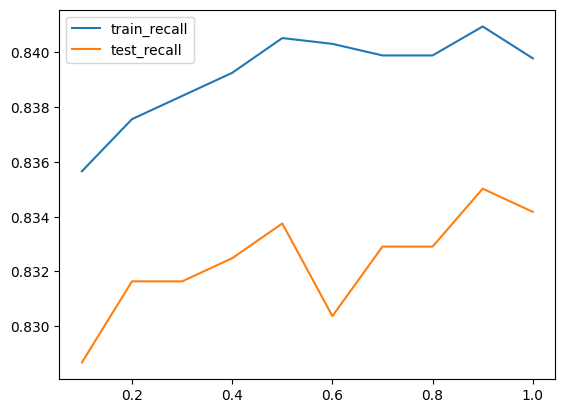

In [54]:
# model definition
rf_cv = GridSearchCV(estimator=rf_clf_default,
                     # what the user care is the model ability to find class 1.
                     # but if the precision is low, it will cause miss opportunity
                     # for the bank to loan money
                     scoring=scoring,
                     refit="recall",
                     return_train_score=True,
                     param_grid={
                        'randomforestclassifier__max_depth': [5],
                        'randomforestclassifier__min_samples_split': [4],
                        # 'randomforestclassifier__max_leaf_nodes': [17],
                        # 'randomforestclassifier__min_samples_leaf': [1],
                        'randomforestclassifier__n_estimators': [96],
                        'randomforestclassifier__max_samples': np.arange(start=0.1, stop=1.1, step=0.1),
                     },
                     n_jobs=-1)

rf_cv.fit(X=X_train, y=y_train)

display("best params", rf_cv.best_params_)
print("best test recall score weighted", rf_cv.best_score_)

sns.lineplot(x=rf_cv.cv_results_['param_randomforestclassifier__max_samples'], 
             y=rf_cv.cv_results_['mean_train_recall'], 
             label="train_recall")
sns.lineplot(x=rf_cv.cv_results_['param_randomforestclassifier__max_samples'],
             y=rf_cv.cv_results_['mean_test_recall'], 
             label="test_recall")

#### 7.2.1.7 - 'max_features'

The recall score weighted stops increasing after max_features 2. However, the recall score did not improve if compared to the previous iteration. Therefore, we will not include this parameter.

The f1 score weighted shows that the model starts to overfit after max_features 2.

'best params'

{'randomforestclassifier__max_depth': 5,
 'randomforestclassifier__max_features': 2,
 'randomforestclassifier__max_samples': 0.9,
 'randomforestclassifier__min_samples_split': 4,
 'randomforestclassifier__n_estimators': 96}

best test recall score weighted 0.8350234708137745


<AxesSubplot: >

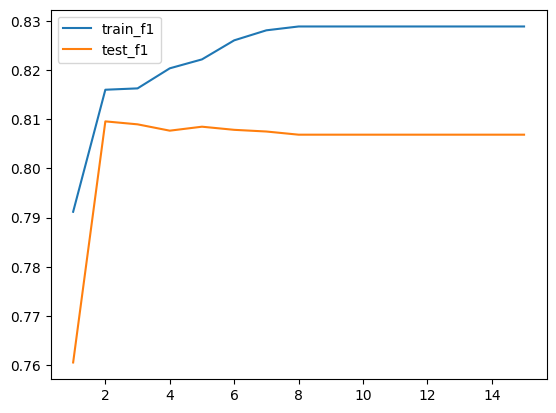

In [55]:
# model definition
rf_cv = GridSearchCV(estimator=rf_clf_default,
                     # what the user care is the model ability to find class 1.
                     # but if the precision is low, it will cause miss opportunity
                     # for the bank to loan money
                     scoring=scoring,
                     refit="recall",
                     return_train_score=True,
                     param_grid={
                        'randomforestclassifier__max_depth': [5],
                        'randomforestclassifier__min_samples_split': [4],
                        # 'randomforestclassifier__max_leaf_nodes': [17],
                        # 'randomforestclassifier__min_samples_leaf': [1],
                        'randomforestclassifier__n_estimators': [96],
                        'randomforestclassifier__max_samples': [0.9],
                        'randomforestclassifier__max_features': np.arange(start=1,stop=16,step=1),
                     },
                     n_jobs=-1)

rf_cv.fit(X=X_train, y=y_train)

display("best params", rf_cv.best_params_)
print("best test recall score weighted", rf_cv.best_score_)

sns.lineplot(x=rf_cv.cv_results_['param_randomforestclassifier__max_features'], 
             y=rf_cv.cv_results_['mean_train_f1'], 
             label="train_f1")
sns.lineplot(x=rf_cv.cv_results_['param_randomforestclassifier__max_features'],
             y=rf_cv.cv_results_['mean_test_f1'], 
             label="test_f1")

In [56]:
# define the model
rf_clf_tuned = make_pipeline(*preprocessor_v2, 
                             RandomForestClassifier(
                                random_state=17,
                                max_depth=5,
                                min_samples_split=4,
                              #   max_leaf_nodes=17,
                              #   min_samples_leaf=1,
                                n_estimators=96,
                                max_samples=0.9,
                              #   max_features=2
                             ))

In [57]:
# Train the algorithm with tuned parameters
rf_clf_tuned.fit(X=X_train, y=y_train)

print("done")

done


# 8 - Model Evaluation
  > Pada bagian ini, dilakukan evaluasi model yang harus menunjukkan bagaimana performa model berdasarkan metrics yang dipilih. Hal ini harus dibuktikan dengan visualisasi tren performa dan/atau tingkat kesalahan model. **Lakukan analisis terkait dengan hasil pada model dan tuliskan hasil analisisnya**.

Goal: To validate if the metrics aree consistent and not due to data leakage.

Metrics used are: `sklearn.metrics.precision_score`, `sklearn.metrics.recall_score`, `sklearn.metrics.f1_score` with parameter 'average=None' and `sklearn.metrics.accuracy_score`.

Task:
1. metrics interpretation.
2. weakness/strength of the model.
3. improvement.

In [58]:
# method to display cross validate result
def cross_validate_display(estimator):
    # shuffle=True because the data is unordered in nature i.e non-Time series
    sss = StratifiedShuffleSplit(random_state=17)
    cv_result = cross_validate(estimator=estimator, cv=sss, X=X_train, y=y_train,
                               scoring=scoring, return_train_score=True)

    # arithmetic mean is used because the number of samples are equal.
    get_mean_std = lambda array: [array.mean(), array.std()]

    with pd.option_context("display.float_format", "{:.3f}".format):
        print("weighted")
        display(pd.DataFrame(data={
            'train recall': get_mean_std(cv_result['train_recall']),
            'test recall': get_mean_std(cv_result['test_recall']),
            'train precision': get_mean_std(cv_result['train_precision']),
            'test precision': get_mean_std(cv_result['test_precision']),
            'train f1': get_mean_std(cv_result['train_f1']),
            'test f1': get_mean_std(cv_result['test_f1']),
            'train balanced_accuracy': get_mean_std(cv_result['train_balanced_accuracy']),
            'test balanced_accuracy': get_mean_std(cv_result['test_balanced_accuracy']),
                             },
                             index=['mean', 'std']).T)

## 8.1 - Default Parameters

### 8.1.1 - Logistic Regression

The recall score weighted are 0.81 and 0.80. The model is a good fit.

The precision score weighted are 0.80 and 0.77. The model tends to 'false positive' with never seen data.

The f1 score weigted are 0.76 and 0.74. The model is a good fit.

Strength:
1. It scales. It just simple equation of `p = 1 / (1 + e^-(b0 + b1x) )`.

Weakness:
1. It is sensitive to errors. If a user did not fill the 'marital_status', the model will be more likely to label it as class 1.

Improvement:
1. We can increase the regularization strength by decreasing the `C` parameter.

In [59]:
# cross validate
cross_validate_display(estimator=log_reg_default)

weighted


,mean,std
train recall,0.813,0.003
test recall,0.801,0.014
train precision,0.807,0.005
test precision,0.777,0.028
train f1,0.763,0.006
test f1,0.748,0.021
train balanced_accuracy,0.580,0.008
test balanced_accuracy,0.567,0.027


### 8.1.2 - SVM

The recall weighted score are 0.78 and 0.78. This model is a good fit.

The precision weighted score are 0.79 and 0.63. This model tends to 'false positive' with never seen data.

The f1 weighted score are 0.69 and 0.69. This is model a good fit.

Strength:
1. It can separate class that can't be linearly separated. i.e feature X1 in x-axis and feature X2 in y-axis, but the class 0 points are in the middle ring and class 1 points are in the outer ring. SVM can solve it by calculating the third vector `X1^2 + X2^2`. Now we can separate the class linearly.

Weakness:
1. Large dataset will result in lots of support vectors. Thus, easy to overfit.

Improvement:
1. We can decrease the regularization strength by increasing the `C` parameter and `gamma` parameter.

#### Ask Instructor

- [ ] How to encode column 'default_payment_next_month' with LabelEncoder or OneHotEncoder in a Pipeline?

In [60]:
cross_validate_display(estimator=svm_default)

weighted


,mean,std
train recall,0.788,0.000
test recall,0.785,0.001
train precision,0.790,0.085
test precision,0.638,0.065
train f1,0.695,0.001
test f1,0.691,0.003
train balanced_accuracy,0.502,0.001
test balanced_accuracy,0.501,0.003


### 8.1.3 - Decision Tree

The recall score weighted is 1.0 and 0.72. This model is overfitted. This model tends to 'false negative' with never seen data.

The precision score weighted is 1.0 and 0.72. This model is overfitted. This model tends to 'false positive' with never seen data.

The f1 score weighted is 1.0 and 0.72. This model is overfitted.

The high recall weighted, precision weighted and f1 weighted is due to imbalance dataset and more rows are class 0 instead of class 1.

Strength:
1. It can solve non-linear problem.
2. It is not sensitive to outliers. Beware, pre-pruning or increasing the `min_samples_leaf` parameter can makes the model to be more sensitive with outliers. (Because instead of trying to get the lower Sum of Squared Residuals, the algorithm will prioritize the `min_samples_leaf` and stop splitting)

Weakness:
1. The higher the variance, the more likely the model to have lots of decision nodes and leaf. The computational cost will be high.
2. It is easy for the model to be overfitted. It is also dangerous because if the the test set we have is actually a seen data in the train set, we will get high recall score with the train set and test set. But by the time we test it on actual never seen data, the model will be more likely to mislabel.

Improvement:
1. We can do pruning by limiting the `max_depth`, increasing the `min_samples_split`, `min_samples_leaf` or use Random Forest Tree.

In [61]:
# cross validate
cross_validate_display(estimator=tree_clf_default)

weighted


,mean,std
train recall,1.000,0.000
test recall,0.723,0.017
train precision,1.000,0.000
test precision,0.721,0.015
train f1,1.000,0.000
test f1,0.721,0.014
train balanced_accuracy,1.000,0.000
test balanced_accuracy,0.586,0.023


### 8.1.4 - KNN

The recall weighted score is 0.82 and 0.76. This indictes that the model is overfit. Thi indicates that the model is overfit and tends to 'false positive'

The precision weighted score is 0.80 and 7.11. This indicates that the model is overfit and tends to 'false positive'

The f1 weighted score is 0.79 and 0.72.

The high recall weighted, precision weighted and f1 weighted is due to imbalance dataset and more rows are class 0 instead of class 1.

Strength:
1. No training.

Weakness:
1. The larger the dataset. The larger model's memory size is.
2. We need to tune the model by increasing or decreasing the `n_neighbors` parameter. We need to find the balance between accuracy score with train set and test set.

Improvement:
1. We can try to increase the `n_neighbors` to find the lowest difference between accuracy score, recall score for class 1 with train set and test set.

In [62]:
# cross validate
cross_validate_display(estimator=knn_default)

weighted


,mean,std
train recall,0.823,0.004
test recall,0.768,0.008
train precision,0.807,0.007
test precision,0.711,0.017
train f1,0.793,0.006
test f1,0.722,0.012
train balanced_accuracy,0.630,0.009
test balanced_accuracy,0.541,0.017


### 8.1.5 - Naive Bayes

The recall score weighted is 0.75 and 0.74. This model is a good fit.

The precision score weighted is 0.78 and 0.76. This model is a good fit.

The f1 score weighted is 0.76 and 0.75. This model is a good fit.

Strength:
1. No training. Just a probability calculation of each nominal label.
2. Good for nomial features.

Weakness:
1. Naively believe that feature do not affect other feature. For example 'bill_amt_2' will be affected by 'pay_amt_1'.
2. Over sampling will cause the priori probability to be false. In this case, 0.5 and 0.5 because we oversampled the data.

Weakness for nominal features:
1. Given how bayes equation is `P(A|B) = P(B|A) * P(A) / P(B)`. The model will definitely mislabel when faced with never seen nominal category. ie The model never see class 1 with 'pay_6' -1 (paid duly). The moment the model is given 'pay_6' -1, the model will always label the instance as class 0. This is because `P(A|class 1)` will be 0.
2. Knowning that problem, the solution is to add class 1 with 'pay_6' -1 in the training set (and other ordinal, nominal features). The amount of time to data preproceess with this model is unfamothable.

Weakness for numerical features:
1. Sensitive to outliers. ie 'bill_amt_1' standard deviation for class 1 is 1 and 10 for class 0. The probability `P(bill_amt_1|class 1)` will always be larger than `P(bill_amt_1|class 0)`. This will make the model more likely to label everything as class 1.

Improvement:
1. If we know the industry standard of ratio of default payment vs not default payment. We can define the priors parameter. Otherwise, we believe, this model can't be improved aside to keep updating it with new dataset.

In [63]:
# cross validate
cross_validate_display(estimator=nb_default)

weighted


,mean,std
train recall,0.757,0.034
test recall,0.743,0.048
train precision,0.780,0.009
test precision,0.766,0.027
train f1,0.765,0.025
test f1,0.751,0.039
train balanced_accuracy,0.679,0.008
test balanced_accuracy,0.658,0.037


### 8.1.6 - Random Forest

The recall weighted score is 1.0 and 0.81. This model is overfitted.

The precision weighted score is 1.0 and 0.79. This model is overfitted.

The f1 weighted score is 1.0 and 0.79. This model is overfitted.

Strength:
1. Decision Tree strengths.
2. It fixes Decision Tree weakness by bagging / parallel voting.   

Weakness:
1. Decision Tree weaknesses.
2. We need to tune the algorithm. Otherwise, it will always overfit. It takes time.

Improvement:
1. We can do pruning with the exact parameters with Decision Tree, with addition of `n_estimators`.

In [64]:
# cross validate
cross_validate_display(estimator=rf_clf_default)

weighted


,mean,std
train recall,1.000,0.000
test recall,0.815,0.027
train precision,1.000,0.000
test precision,0.795,0.038
train f1,1.000,0.000
test f1,0.791,0.031
train balanced_accuracy,1.000,0.001
test balanced_accuracy,0.637,0.042


## 8.2 - Random Forest with Tuned Parameters

The recall weighted score increased by 1% (test set).

The f1 weighted score indicates that the model is a good fit.

The balanced_accuracy increased by 0.5% (test set).

In [65]:
# croos validate
cross_validate_display(estimator=rf_clf_tuned)

weighted


,mean,std
train recall,0.841,0.003
test recall,0.825,0.021
train precision,0.833,0.004
test precision,0.810,0.030
train f1,0.816,0.003
test f1,0.797,0.028
train balanced_accuracy,0.662,0.005
test balanced_accuracy,0.642,0.043


In [66]:
# preview classification report 
def isolate():
    y_test_pred = rf_clf_tuned.predict(X=X_test)
    print(classification_report(y_true=y_test, y_pred=y_test_pred))

isolate()

              precision    recall  f1-score   support

           0       0.85      0.97      0.91       465
           1       0.80      0.39      0.52       126

    accuracy                           0.85       591
   macro avg       0.83      0.68      0.72       591
weighted avg       0.84      0.85      0.83       591



/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [67]:
# Save the model
def isolate():
    with open('./model/rf_clf_tuned/v1/pipeline.pkl', 'wb') as file_1:
        joblib.dump(rf_clf_tuned, file_1)

isolate()

# 8 - Model Inference

## 8.1 - Random Forest with Tuned Parameters

In [68]:
# Model Loading
def isolate():
    global rf_clf_tuned
    with open('./model/rf_clf_tuned/v1/pipeline.pkl', 'rb') as file_1:
        rf_clf_tuned = joblib.load(file_1)

isolate()

In [69]:
def isolate():
    y_true = inference_set['default_payment_next_month']
    y_pred = rf_clf_tuned.predict(inference_set)
    print("y_true", y_true.to_numpy())
    print("y_pred", y_pred)

    print("recall score for class 1", 
          recall_score(y_true=y_true, y_pred=y_pred, pos_label=1))
    print("f1 score for class 1", f1_score(y_true=y_true, y_pred=y_pred, pos_label=1))

    with pd.option_context("display.max_columns", None):
        display(inference_set.iloc[[5,7,8,9]])

isolate()

y_true [0 0 0 0 0 1 1 1 1 1]
y_pred [0 0 0 0 0 0 1 0 0 0]
recall score for class 1 0.2
f1 score for class 1 0.33333333333333337


,limit_balance,sex,education_level,marital_status,age,pay_0,pay_2,pay_3,pay_4,pay_5,pay_6,bill_amt_1,bill_amt_2,bill_amt_3,bill_amt_4,bill_amt_5,bill_amt_6,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,pay_amt_6,default_payment_next_month
2546,450000,2,2,1,38,-2,-2,-2,-2,-2,-2,390,390,390,390,390,390,390,780,390,390,390,390,1
1193,40000,2,2,2,23,-1,2,-1,-1,0,0,652,326,326,26370,24572,24918,0,326,26370,886,1075,830,1
2059,360000,2,3,2,42,-2,-2,-2,-2,-2,-2,0,0,0,0,0,0,0,0,0,0,0,0,1
1686,80000,2,2,1,29,-2,-2,-1,2,2,-2,2801,0,21197,20400,20000,20000,0,21197,0,0,0,0,1


# 9 - Pengambilan Kesimpulan
  > Pada bagian terakhir ini, **harus berisi** kesimpulan yang mencerminkan hasil yang didapat dengan _objective_ yang sudah ditulis di bagian pengenalan.

The dataset is mildly imbalance (1:5 ratio) [outline](#42---imbalance-dataset). Each rows are unique (due to 'bill_amt_1' to 'bill_amt_6'). Therefore, we did not do under sampling to avoid losing information. However, due to low correlation between X numerical and y Categorical, X ordinal and y Categorical. We decided not to over sampling the dataset.

Also, we found out that there are errors (41% index, there are duplicated index). The decision was to find a way to just replace the wrong value instead of dropping the column. We managed to create a strategy to just drop 23 rows. However, knowning that we can't confirm to the dataset owner whether the presumed errors are actually errors. We did not replace or remove errors from the test set.

The objective was to build a model that have f1 score of 0.9 for class 1. However, after selecting the best algorithm and tuning the parameters. The best f1 weighted score is 0.83 (test set) [outline](#82---random-forest-with-tuned-parameters).

The model is far from production ready. Although the f1 weighted score is 0.83. The recall score class 1 actually is only 0.52. This means that model only able to predict 52 people from 100 people that will default.

# Conceptual Problems

1. Apakah fungsi parameter `criterion` pada Decision Tree? Jelaskan salah satu criterion yang kalian pahami!
   1. Criterion is the scoring used by Decision Tree to determine whether the algorithm should split the leaf or not.
   2. in `sklearn.tree.DecisionTreeClassifier` there are gini, entropy and log_loss.
      
      Entropy is sum of `-probability * log₂(probability)`. i.e probability of buying computer:
      1. Entropy(<=30) = 3 people did not buy the computer and 2 people did buy the computer `(-3/5 * log₂(3/5)) + (-2/5 * log₂(2/5))`

      `criterion='gini'` actually use Gain to determine whether to split the leaf or not.

      Gain is the difference between Entropy(Total) and Entropy(Feature). ie `Gain(Feature) = Entropy(Total) - Entropy(Feature)`. The highest Gain(Feature) will be selected to be the next leaf to be splitted.

      Gini is the impurity within a leaf. ie if within a leaf, all of the samples are buying computer. Then, the Gini is 0.

      The gini equation  `1 - squared probability of everyy class within the leaf`. ie if within a leaf there is 1 person did not buy computer, and 5 person did not buy the computer. The Gini is `1 - ( (1/6)² + (5/6)² )` or 0.278

2. Apakah fungsi dari `pruning` pada Tree model?
   1. Pruning is to reduce the decision tree. It is similar to regularization in linear model. It is a way to prevent the model from becoming overfitted.
   2. in `sklearn.tree.DecisionTreeClassifier`, we can change the parameter `min_samples_leaf` and `max_depth` to do pruning.
   3. `min_samples_leaf` prevents the algorithm to split the leaf even though the gini is not 0 if the minimum samples to split is not met.
   4. `max_depth` prevents the algorithm to split the leaf if the maximum depth has been reached.
   5. Becareful of pre-pruning.
   
3. Bagaimana cara memilih `K` yang optimal pada KNN?
   1. There is no statistics equation to find the optimal KNN.
   2. However, always start with small `K` or in `sklearn.neighbors.KNeighborsClassifier` small `n_neighbors` parameter.
   3. Increase the `n_neighbors` one iteration at a time until you get good fit (train set and test set metrics is similar) and stop there. To simplify, use the `sklearn.metrics.accuracy_score` and plot it.
   ![visual](./images/Screen%20Shot%202022-11-13%20at%2017.50.45.png)
   4. `sklearn.neigbors.KNeighborsClassifier` always do multiple calculation for every prediction. In this case, calculating the (usually) euclidean distance between the test point and close train points. Therefore, the higher the `n_neighbors` parameter is set, the more expensive is the computational cost.

4. Jelaskan apa yang kalian ketahui tentang `Cross Validation`!
   1. `sklearn.model_selection.cross_validate` checks if the model metrics are high not because of the test set are actually a seen data set / data leakage.
   2. The idea is to split the train set into X amount of dataset. Each of these dataset will have turn to be used as train set and test set. If there is no data leakage, the model metrics' arithmetic mean should be high and standard deviation should be low.

5. Jelaskan apa yang kalian ketahui tentang `Accuracy, Precision, Recall, F1 Score`!
   Recall class 1:
   1. It explains the model ability to find class 1.

   Precision class 1:
   1. It explains the model ability to not label an instance as class 1 that is actually class 0.

   F1 Score:
   1. The harmonic mean of recall and precision.
   2. Harmonic mean is used because recall `tp / (tp + fn)` and precision `tp / (tp + fp)` have different number of samples.
      
      [reference](https://stackoverflow.com/questions/26355942/why-is-the-f-measure-a-harmonic-mean-and-not-an-arithmetic-mean-of-the-precision)
    
   Accuracy:
   1.  It explains the model ability to find class 1 and class 0.

